# Activity experiment processing (2023 - PCB frames)

### Configuration

#### Imports

In [1]:
import numpy
import cv2

%matplotlib widget
import matplotlib
import matplotlib.pyplot
import matplotlib.patches

import scipy
import scipy.ndimage
import scipy.interpolate
import scipy.signal

import os
import time
import io

import sys
import pickle
import tqdm
import math

import activity_experiments_python.bee_activity as BA
import activity_experiments_python.scenario_management as SM

#### General constants definition

In [2]:
# General constants
DATA_RECALCULATION_RPI = False
DATA_RECALCULATION_LEDS = False
FRAMES_TO_PROCESS = 'all'


DATA_FOLDER = '/Users/matthieu/Documents/proto3/Graz2023/April/Activity_experiments/'
DATE_FOLDER = '20230423/'

FOLDER_AMP2 = 'Amp2config/'
FOLDER_DATA = 'data/'
FOLDER_SIGNALS = 'signals/'
FOLDER_SCENARIO = 'scenario/'

EXPERIMENTS = ['3/', '4/', '5/', '6/', '7/', '8_entrance/']
exp_of_interest = 0

exp_folder = DATA_FOLDER+DATE_FOLDER+EXPERIMENTS[exp_of_interest]

available_replicates = [x for x in os.listdir(exp_folder+FOLDER_DATA) if os.path.isdir(exp_folder+FOLDER_DATA+x)]
rep_of_interest = 0
times_folder = exp_folder+FOLDER_DATA+available_replicates[rep_of_interest]+'/'

available_times = [x for x in os.listdir(times_folder) if os.path.isdir(times_folder+x)]
time_of_interest = 0
video_folder = times_folder+available_times[time_of_interest]+'/'

available_videos = [x for x in os.listdir(video_folder) if x.endswith('.mp4')]
videos = {}
for i in range(1,6):
    rpi_name = 'rpi{}'.format(i)
    videos[rpi_name] = [video_folder+x for x in available_videos if 'hive1_rpi{}'.format(i) in x]
    if not(videos[rpi_name] == []):
        videos[rpi_name] = videos[rpi_name][0]

print(videos)
rpi_of_interest = 'rpi4'

{'rpi1': '/Users/matthieu/Documents/proto3/Graz2023/April/Activity_experiments/20230423/3/data/r0/syncd_230423-091427-utc/v_hive1_rpi1_230423-091438-utc.mp4', 'rpi2': '/Users/matthieu/Documents/proto3/Graz2023/April/Activity_experiments/20230423/3/data/r0/syncd_230423-091427-utc/v_hive1_rpi2_230423-091438-utc.mp4', 'rpi3': '/Users/matthieu/Documents/proto3/Graz2023/April/Activity_experiments/20230423/3/data/r0/syncd_230423-091427-utc/v_hive1_rpi3_230423-091438-utc.mp4', 'rpi4': '/Users/matthieu/Documents/proto3/Graz2023/April/Activity_experiments/20230423/3/data/r0/syncd_230423-091427-utc/v_hive1_rpi4_230423-091438-utc.mp4', 'rpi5': '/Users/matthieu/Documents/proto3/Graz2023/April/Activity_experiments/20230423/3/data/r0/syncd_230423-091427-utc/v_hive1_rpi5_230423-091438-utc.mp4'}


#### Folder structure creation

* Working directory : **'./'**
* Saving directory : **'./processed_data/'**
* Experiments directory : **'./processed_data/with_cover/'** or **'./processed_data/without_cover/'**
* Type of data directory : **'./processed_data/with_cover/activity/'** or **'./processed_data/without_cover/activity/'**

If failed, does not mean the directory does not exists. Creation will fail if the directory already exists.

In [3]:
# Folder structure creation

fpath = exp_folder+'/processed_data/'
try:
    os.mkdir(fpath)
except OSError:
    print ("Creation of the directory %s failed" % fpath)
else:
    print ("Successfully created the directory %s " % fpath)
        
    
dpath = fpath + 'activity/'

try:
    os.mkdir(dpath)
except OSError:
    print ("Creation of the directory %s failed" % dpath)
else:
    print ("Successfully created the directory %s " % dpath)


Creation of the directory /Users/matthieu/Documents/proto3/Graz2023/April/Activity_experiments/20230423/3//processed_data/ failed
Creation of the directory /Users/matthieu/Documents/proto3/Graz2023/April/Activity_experiments/20230423/3//processed_data/activity/ failed


### Processing

#### Crops estimation

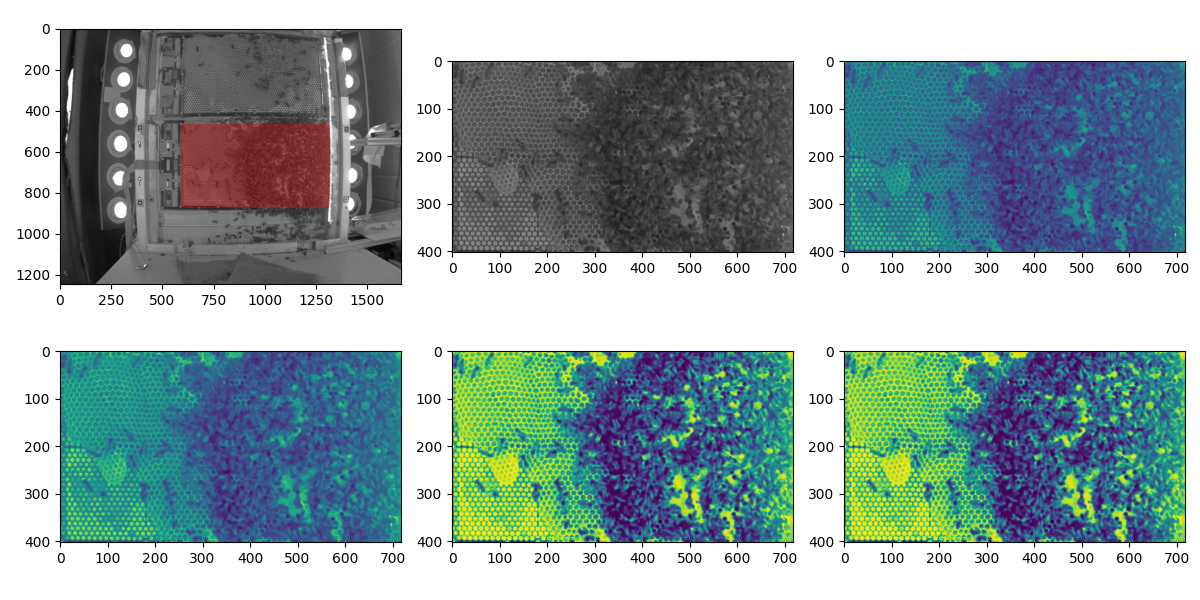

In [4]:
BA.show_video_frame(video=videos[rpi_of_interest], frame_of_interest=90, cropX=[467,869], cropY=[589,1307])

#### Global activity and LED activity computation

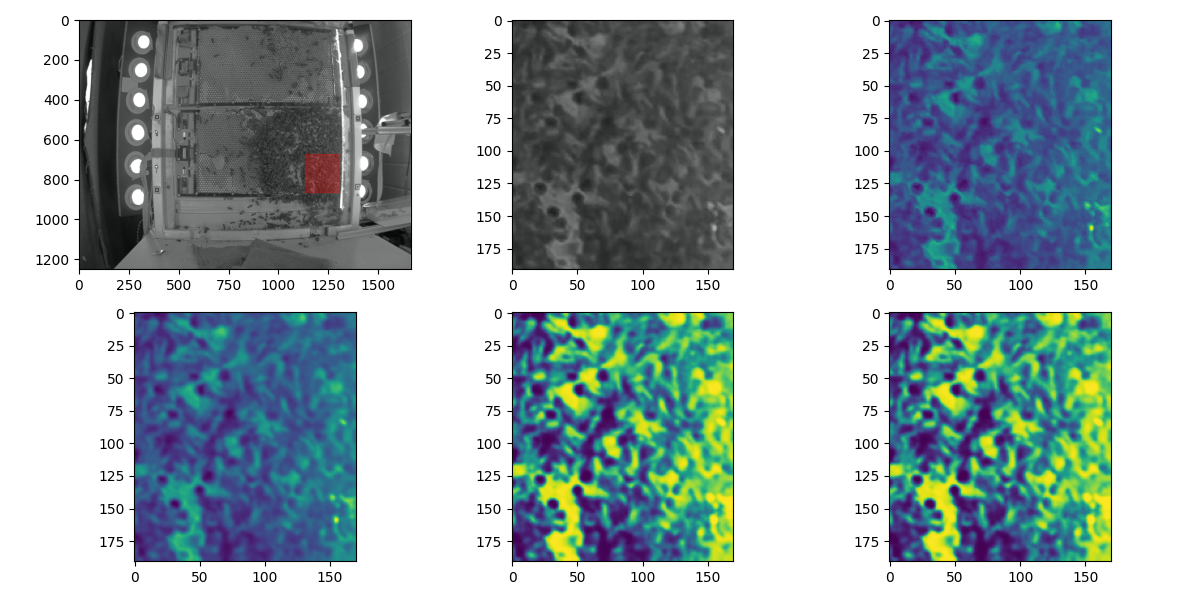

In [5]:
OUTER_CROP_X = [467,869]
OUTER_CROP_Y = [589,1307]
CROP_MARGIN = 10

mapping_index = {7:0, 6:1, 5:2, 4:3, 0:4, 1:5, 2:6, 3:7}
CROPS = {
    '0' : {'x' : [], 'y' : []},
    '1' : {'x' : [], 'y' : []},
    '2' : {'x' : [], 'y' : []},
    '3' : {'x' : [], 'y' : []},
    '4' : {'x' : [], 'y' : []},
    '5' : {'x' : [], 'y' : []},
    '6' : {'x' : [], 'y' : []},
    '7' : {'x' : [], 'y' : []},
    'a' : {'x' : [], 'y' : []}
}

for key in CROPS:
    try : 
        key_int = int(key)
    except :
        key_int = -1
    if not(key_int == -1):
        posx = math.floor(mapping_index[key_int]/4)
        posy = mapping_index[key_int]%4
        # print('key {} : ({},{})'.format(key, posx, posy))
        CROPS[key]['x'] = [int((OUTER_CROP_X[1]-OUTER_CROP_X[0])/2*posx+CROP_MARGIN/2)+OUTER_CROP_X[0], int((OUTER_CROP_X[1]-OUTER_CROP_X[0])/2*(posx+1)-CROP_MARGIN/2)+OUTER_CROP_X[0]]
        CROPS[key]['y'] = [int((OUTER_CROP_Y[1]-OUTER_CROP_Y[0])/4*posy+CROP_MARGIN/2)+OUTER_CROP_Y[0], int((OUTER_CROP_Y[1]-OUTER_CROP_Y[0])/4*(posy+1)-CROP_MARGIN/2)+OUTER_CROP_Y[0]]
    else :
        posx = math.floor(mapping_index[6]/4)
        posy = mapping_index[6]%4
        CROPS[key]['x'] = [int(CROP_MARGIN/2)+OUTER_CROP_X[0], -int(CROP_MARGIN/2)+OUTER_CROP_X[1]]
        CROPS[key]['y'] = [int(CROP_MARGIN/2)+OUTER_CROP_Y[0], -int(CROP_MARGIN/2)+OUTER_CROP_Y[1]]

test_zone = '3'
BA.show_video_frame(video=videos[rpi_of_interest], frame_of_interest=90, cropX=CROPS[test_zone]['x'], cropY=CROPS[test_zone]['y'])
# show_video_frame(xps[xp_to_process]['video'], frame_of_interest=1500, cropX=CROP_LED_X_R3, cropY=CROP_LED_Y_R3)

In [6]:
# Experiments gathering
if DATA_RECALCULATION_RPI:
    datapack = {}
    
    for key in CROPS.keys():
        activities = BA.compute_video_activity(videos[rpi_of_interest], frames='all', cropX=CROPS[key]['x'], cropY=CROPS[key]['y'])
        datapack[key] = {}
        datapack[key]['act'] = activities
        datapack[key]['fname'] = videos[rpi_of_interest]
        datapack[key]['crop'] = CROPS[key]
        datapack[key]['pos'] = key
    
    with open(dpath + available_replicates[rep_of_interest]+'_'+rpi_of_interest+'_activities.json', 'wb') as fp:
        pickle.dump(datapack, fp)
else :
    with open(dpath + available_replicates[rep_of_interest]+'_'+rpi_of_interest+'_activities.json', 'rb') as fp:
        datapack = pickle.load(fp)

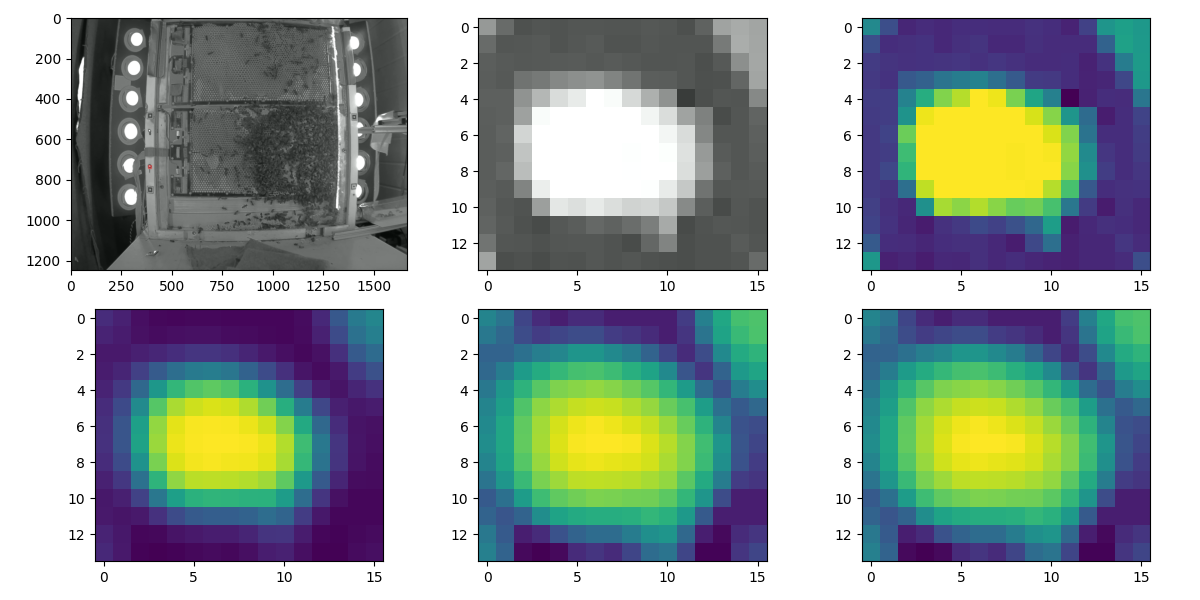

In [7]:
LED_CROPS = {
    '0' : {'x' : [554,570], 'y' : [381,397]},
    '1' : {'x' : [728,742], 'y' : [381,397]}
}

test_led = '1'
BA.show_video_frame(video=videos['rpi4'], frame_of_interest=90, cropX=LED_CROPS[test_led]['x'], cropY=LED_CROPS[test_led]['y'])

In [8]:
if DATA_RECALCULATION_LEDS:
    leds_datapack = {}
    
    for key in LED_CROPS.keys():
        activities = BA.compute_video_intensity(videos['rpi4'], frames='all', cropX=LED_CROPS[key]['x'], cropY=LED_CROPS[key]['y'])
        leds_datapack[key] = {}
        leds_datapack[key]['act'] = activities
        leds_datapack[key]['fname'] = videos['rpi4']
        leds_datapack[key]['crop'] = LED_CROPS[key]
        leds_datapack[key]['pos'] = key
    
    with open(dpath + available_replicates[rep_of_interest]+'_leds_intensities.json', 'wb') as fp:
        pickle.dump(leds_datapack, fp)
else :
    with open(dpath + available_replicates[rep_of_interest]+'_leds_intensities.json', 'rb') as fp:
        leds_datapack = pickle.load(fp)

#### Theoritical LED intensities from scenario file

In [13]:
scenario_folder = exp_folder+FOLDER_SCENARIO
scenario_file = [x for x in os.listdir(scenario_folder) if x.endswith('.txt')][0]

print('Processing scenario file : '+scenario_file)

theory_l0, theory_l1 = SM.extract_theoritical_led_intensity(scenario_folder+scenario_file)
theory_leds = {'0':theory_l0, '1':theory_l1}
theory_leds['times'] = numpy.array(range(theory_leds['0'].shape[0]))

Processing scenario file : activity_exp_scenario.txt


## Results 

119.5


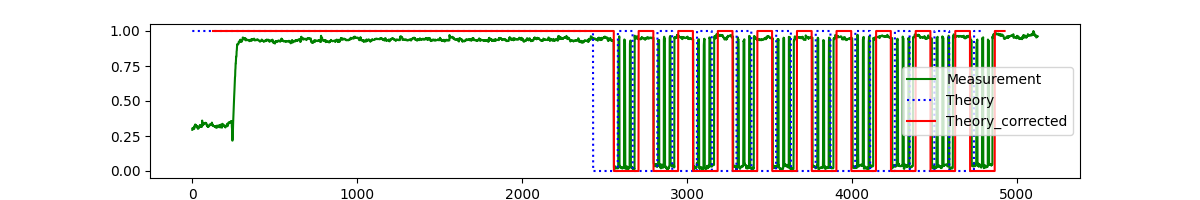

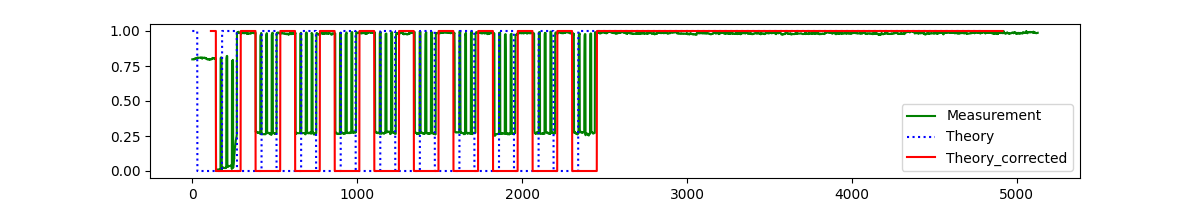

In [14]:
shifts = []

for idkey, key in enumerate(leds_datapack.keys()):
    shifts.append(SM.compute_time_shift(leds_datapack[key]['act'], theory_leds[key]))

led_time_shift = numpy.mean(numpy.array(shifts))
print(led_time_shift)

theory_leds['corrected_times'] = theory_leds['times']+led_time_shift

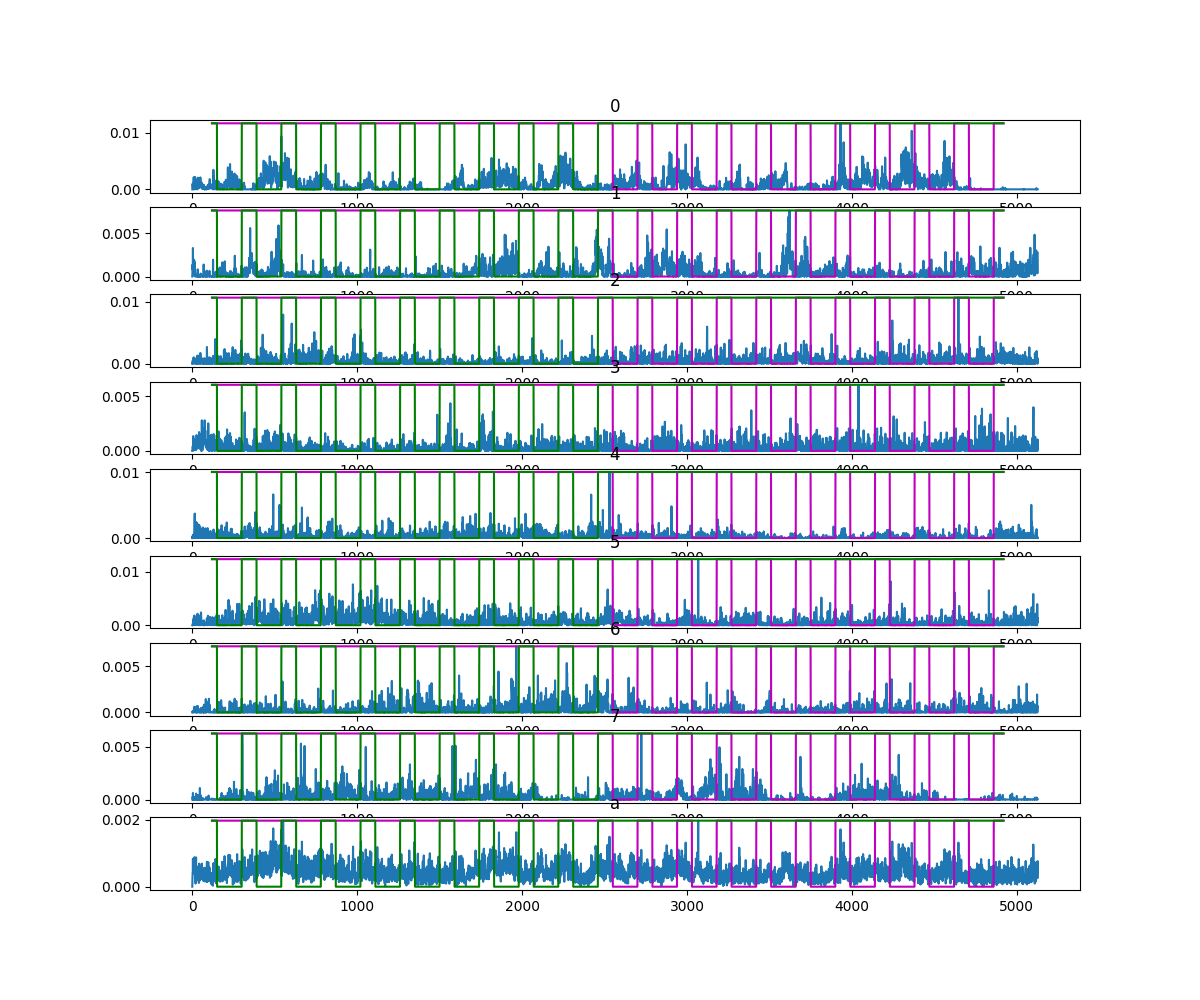

In [17]:
fig, ax = matplotlib.pyplot.subplots(9, 1, figsize=(12,10))
for idkey, key in enumerate(datapack.keys()):
    activity = datapack[key]['act']
    ax[idkey].plot(range(len(activity)), activity)
    ax[idkey].plot(theory_leds['corrected_times'], theory_leds['0']*max(activity), 'm')
    ax[idkey].plot(theory_leds['corrected_times'], theory_leds['1']*max(activity), 'g')
    ax[idkey].set_title(datapack[key]['pos'])